In [1]:
import pandas as pd
import spacy 
#from rutermextract import TermExtractor
import string
from nltk import word_tokenize
from wordcloud import WordCloud
import re
from collections import Counter
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
import pymorphy2
from nltk.probability import FreqDist
import operator
import numpy as np
import upsetplot

In [2]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

In [3]:
from jupyter_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.express as px
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output

In [8]:
df = pd.read_csv('опрос.csv', sep=';', comment='#', engine = 'python', encoding = 'utf-8')

#### Анонимизация ответов

In [10]:
df['Student_id'] = df['ФИО'].rank(method = 'dense')
del df['Unnamed: 5'], df['ФИО']

In [11]:
df = df[['Student_id', 'Вопрос', 'ответ', 'дата ответа', 'комментарий']]
df.tail(5)

,Student_id,Вопрос,ответ,дата ответа,комментарий
85574,3574.0,Что в курсе Вам НЕ понравилось?,"Проектные задания, ожидание проверки работ",25.08.2020 7:11,NaN
85575,3574.0,Что из содержания курса для Вас оказалось сове...,Все необходимо,25.08.2020 7:11,NaN
85576,3574.0,Ваши конструктивные предложения по улучшению к...,Уменьшить количество проектных заданий,25.08.2020 7:11,NaN
85577,3574.0,Планируете ли Вы принять участие в следующем к...,"да,",25.08.2020 7:11,NaN
85578,3574.0,Порекомендуете ли Вы коллегам участие в курсе?,да,25.08.2020 7:11,NaN


In [7]:
set(df['Вопрос'])

{'Ваши конструктивные предложения по улучшению курса?',
 'Какие смыслы / инициативы по цифровой трансформации Вашей школы удалось сформировать на курсе?',
 'Какие темы Вы планируете изучить подробнее после курса?',
 'Какие темы были для Вас наиболее полезны?',
 'Какие типы материалов были Вам наиболее удобны для работы?',
 'Кто из спикеров Вам понравился (можно несколько фамилий)?',
 'Насколько курс был интересен для Вас?',
 'Планируете ли Вы принять участие в следующем курсе?',
 'Порекомендуете ли Вы коллегам участие в курсе?',
 'Что в курсе Вам НЕ понравилось?',
 'Что в курсе Вам понравилось?',
 'Что из содержания курса для Вас оказалось наиболее новым / прорывным для профессиональной деятельности?',
 'Что из содержания курса для Вас оказалось совершенно неприемлемым / неприменимым и почему?'}

In [8]:
#количество студентов
len(set(df['Student_id']))

5798

In [12]:
import warnings
warnings.filterwarnings('ignore')

## Какие типы материалов были Вам наиболее удобны для работы?

In [13]:
df_mat = df[df['Вопрос'] == 'Какие типы материалов были Вам наиболее удобны для работы?']
df_mat.drop_duplicates(['Student_id'],keep = 'last', inplace  = True)
df_mat.fillna('нет ответа', inplace=True)
df_mat.reset_index(inplace = True)
del df_mat['index']

In [14]:
txt =''
for x in df_mat['ответ']:
    txt+=x+' '
txt = txt.lower()
text = [i for i in re.split('; ',txt)]

In [15]:
settext = {x for x in df_mat['ответ']}
material = []
for x in settext:
    for i in re.split('; ',x):
        material.append(i)
materials_liked = set(material)
materials_liked.discard('')

In [16]:
import operator
materials_dict = {material.strip(): txt.count(material.strip()) for material in materials_liked}
materials_dict_sort = sorted(materials_dict.items(), key=operator.itemgetter(1),reverse=True)
materials_dict_sort

[('презентация', 4759),
 ('видеолекция', 4377),
 ('ссылка в интернет', 2377),
 ('звуковая дорожка', 1266),
 ('анонс', 734),
 ('нет ответа', 169)]

In [17]:
d = pd.DataFrame(materials_dict_sort)
d.columns = ['Материал','Частота упоминаний']
fig = px.bar(d, x= "Материал", y="Частота упоминаний")

### Визуализация пересечений ответов

In [17]:
t = []
col_names = [x for x in  materials_dict]
for i in range(len(df_mat)):
    temp = []
    for x in materials_dict:
        if(df_mat['ответ'][i].find(x)!=-1):
            temp.append(True)
        else: temp.append(False)
    #upset_df[col_names] = temp
    t.append(temp)

In [18]:
upset_df = pd.DataFrame()
upset_df = pd.DataFrame(t, columns = col_names)
upset_df['c'] = 1
example = upset_df.groupby(col_names).count().sort_values('c')


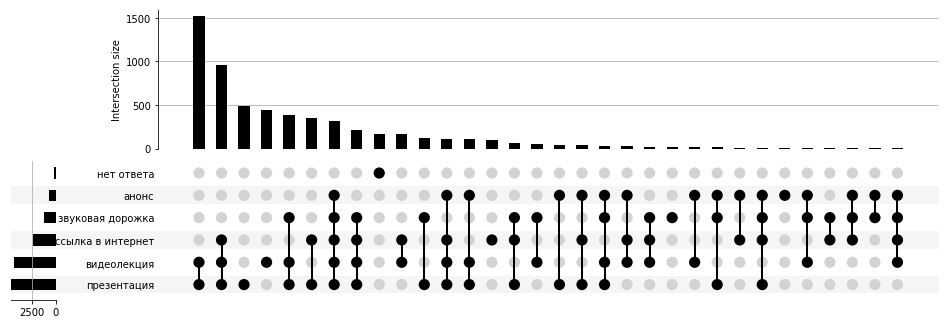

In [20]:
upsetplot.plot(example['c'], sort_by="cardinality")
plt.title('', loc='left')
plt.show()

# Кто из спикеров Вам понравился (можно несколько фамилий)?

In [21]:
df_who = df[df['Вопрос'] == 'Кто из спикеров Вам понравился (можно несколько фамилий)?']
df_who.drop_duplicates(['Student_id'],keep = 'last', inplace  = True)
without_answer = df_who['ответ'].isnull().sum()
df_who.dropna(subset=['ответ'], inplace=True)
df_who.reset_index(inplace = True)
del df_who['index']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [22]:
#df_who['ФИО'].un
df['Student_id'].nunique()

5798

In [23]:
df_who.head(10)

,Student_id,Вопрос,ответ,дата ответа,комментарий
0,3437.0,Кто из спикеров Вам понравился (можно нескольк...,.,13.06.2020 23:47,NaN
1,1625.0,Кто из спикеров Вам понравился (можно нескольк...,все,14.06.2020 9:25,NaN
2,4848.0,Кто из спикеров Вам понравился (можно нескольк...,"Катерина Поливанова, Асмолов А.Г.",14.06.2020 13:37,NaN
3,5621.0,Кто из спикеров Вам понравился (можно нескольк...,Все,15.06.2020 10:03,NaN
4,2993.0,Кто из спикеров Вам понравился (можно нескольк...,Все,16.06.2020 8:58,NaN
5,5053.0,Кто из спикеров Вам понравился (можно нескольк...,"Лика Чекалова, Асмолов А.Г., Панюкова С.В и др.",16.06.2020 13:47,NaN
6,2050.0,Кто из спикеров Вам понравился (можно нескольк...,Все спикеры,16.06.2020 14:11,NaN
7,3727.0,Кто из спикеров Вам понравился (можно нескольк...,"П. Лукша, К. Баранников",16.06.2020 20:01,NaN
8,3996.0,Кто из спикеров Вам понравился (можно нескольк...,Павел Рабинович,17.06.2020 8:53,NaN
9,2460.0,Кто из спикеров Вам понравился (можно нескольк...,"Алексей Семенов, Дина Баясанова, Светлана Паню...",17.06.2020 9:56,NaN


In [24]:
spec_chars = string.punctuation + '\n\r\xa0«»\t—…'
txt =''
for x in df_who['ответ']:
    txt+=x+' '
txt = txt.lower()

In [25]:
text_tokens = word_tokenize(txt)
text = nltk.Text(text_tokens)
text

<Text: . все катерина поливанова , асмолов а.г ....>

In [26]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.remove('все')

In [27]:
morph = pymorphy2.MorphAnalyzer()

In [28]:
names = []
for x in text_tokens:
    for p in morph.parse(x):
        if 'Name' in p.tag and p.score >= 0.5:
            #print('{:<12}\t({:>12})\tscore:\t{:0.3}'.format(x, p.normal_form, p.score))
            names.append(x)
names_set = set(names)
names_set.add('лика')
names_set.add('роман')

In [29]:
t=[]
for xi in text_tokens:
    x = "".join([ch for ch in xi if ch not in spec_chars])
    if((x not in names_set) and x not in russian_stopwords and x not in spec_chars and len(x)>2):
        t.append(x)
text = nltk.Text(t)

In [30]:
fdist_sw = FreqDist(text)
fd = dict(fdist_sw)
del fd['спикеры'], fd['спасибо'], fd['выделить'], fd['очень'], fd['понравились'], fd['могу'], fd['каждый'], fd['интересны']
del fd['молодцы'], fd['материал'], fd['викторович'], fd['всем'], fd['когото'], fd['мкушнир'], fd['спикеров']

In [31]:
fd['нет ответа'] =  without_answer

In [32]:
who_dict_sort = sorted(fd.items(), key=operator.itemgetter(1),reverse=True)
who_dict_sort[:20]

[('все', 1256),
 ('нет ответа', 910),
 ('душкин', 852),
 ('рабинович', 827),
 ('кушнир', 657),
 ('лукша', 496),
 ('асмолов', 416),
 ('чекалова', 320),
 ('уваров', 241),
 ('заведенский', 239),
 ('казакова', 229),
 ('семенов', 196),
 ('пахчанян', 168),
 ('степанов', 162),
 ('солдатова', 162),
 ('баранников', 159),
 ('панюкова', 139),
 ('гулин', 136),
 ('киселева', 91),
 ('ильина', 74)]

In [33]:
d = pd.DataFrame(who_dict_sort[:20])
d.columns = ['Спикер','Частота упоминаний']

In [34]:
fig4 = px.bar(d, x="Спикер", y="Частота упоминаний")


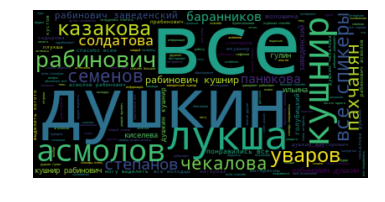

In [35]:
text_raw = " ".join(text)
wordcloud = WordCloud().generate(text_raw)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Порекомендуете ли Вы коллегам участие в курсе?

In [36]:
df_recom = df[df['Вопрос'] == 'Порекомендуете ли Вы коллегам участие в курсе?']
df_recom.drop_duplicates(['Student_id'],keep = 'last', inplace  = True)
without_answer = df_recom['ответ'].isnull().sum()
df_recom.dropna(subset=['ответ'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [37]:
df_recom.reset_index(inplace = True)
del df_recom['index']

In [38]:
df_recom.index

RangeIndex(start=0, stop=5549, step=1)

In [39]:
df_recom.head()

,Student_id,Вопрос,ответ,дата ответа,комментарий
0,3427.0,Порекомендуете ли Вы коллегам участие в курсе?,да,12.06.2020 18:18,NaN
1,5443.0,Порекомендуете ли Вы коллегам участие в курсе?,да,12.06.2020 18:23,NaN
2,3437.0,Порекомендуете ли Вы коллегам участие в курсе?,да,13.06.2020 23:47,NaN
3,1625.0,Порекомендуете ли Вы коллегам участие в курсе?,да,14.06.2020 9:25,обязательно
4,4848.0,Порекомендуете ли Вы коллегам участие в курсе?,да,14.06.2020 13:37,NaN


In [40]:
answer = set(df_recom['ответ'])
txt =''
for x in df_recom['ответ']:
    txt+=x+' '
txt = txt.lower()

In [41]:
answer_dict = {x: txt.count(x) for x in answer}
answer_dict['нет ответа'] = without_answer
answer_dict = sorted(answer_dict.items(), key=operator.itemgetter(1),reverse=True)

In [42]:
d = pd.DataFrame(answer_dict)
d.columns = ['Ответ','Частота упоминаний']
d

,Ответ,Частота упоминаний
0,да,5363
1,нет ответа,249
2,нет,186


In [43]:
fig1 = px.bar(d, x="Ответ", y="Частота упоминаний")


## Планируете ли Вы принять участие в следующем курсе?

In [44]:
df_recom = df[df['Вопрос'] == 'Планируете ли Вы принять участие в следующем курсе?']
df_recom.drop_duplicates(['Student_id'],keep = 'last', inplace  = True)
without_answer = df_recom['ответ'].isnull().sum()
df_recom.dropna(subset=['ответ'], inplace=True)
answer = set(df_recom['ответ'])
txt =''
for x in df_recom['ответ']:
    txt+=x+' '
txt = txt.lower()
answer_dict = {x: txt.count(x) for x in answer}
answer_dict['нет ответа'] = without_answer
answer_dict = sorted(answer_dict.items(), key=operator.itemgetter(1),reverse=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [45]:
d = pd.DataFrame(answer_dict)
d.columns = ['Ответ','Частота упоминаний']
fig2 = px.bar(d, x="Ответ", y="Частота упоминаний")

## Насколько курс был интересен для Вас?

In [46]:
df_use = df[df['Вопрос'] == 'Насколько курс был интересен для Вас?']
df_use.drop_duplicates(['Student_id'],keep = 'last', inplace  = True)
without_answer = df_use['ответ'].isnull().sum()
df_use.dropna(subset=['ответ'], inplace=True)
answer = set(df_use['ответ'])
txt =''
for x in df_use['ответ']:
    txt+=x+' '
txt = txt.lower()
answer_dict = {x: txt.count(x) for x in answer}
answer_dict['нет ответа'] = without_answer
answer_dict = sorted(answer_dict.items(), key=operator.itemgetter(1),reverse=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [47]:
df_use.index

Int64Index([    0,    26,    65,    78,    91,   117,   156,   195,   208,
              221,
            ...
            85449, 85462, 85467, 85488, 85501, 85514, 85521, 85540, 85553,
            85566],
           dtype='int64', length=5703)

In [48]:
d = pd.DataFrame(answer_dict)
d.columns = ['Ответ','Частота упоминаний']
fig3 = px.bar(d, x="Ответ", y="Частота упоминаний")

In [49]:
#external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']


## Какие темы были для Вас наиболее полезны?

In [50]:
df_use = df[df['Вопрос'] == 'Какие темы были для Вас наиболее полезны?']
without_answer = df_use['ответ'].isnull().sum()
df_use.fillna('нет ответа', inplace=True)
df_use.drop_duplicates(['Student_id'],keep = 'last', inplace  = True)
df_use.reset_index(inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [51]:
without_answer

335

In [52]:
txt =''
for x in df_use['ответ']:
    txt+=x+'; '
txt = txt.lower() + 'нет ответа'
text = [i for i in re.split('; ',txt)]

themes = set(text)
#themes.remove('')

In [53]:
themes

{'1.1.1. тенденции, ситуация, вызовы',
 '1.1.2. национальные и локальные тенденции и повестки',
 '1.1.3. цифровизация государства',
 '1.1.4. цифровизация экономики',
 '1.1.5. цифровая культура и этика',
 '1.1.6. риски и вызовы цифровизации',
 '1.2.1. модель цифровой трансформации образования',
 '1.2.2. образование, как трансформируемая деятельность',
 '1.2.3. цифровые технологии в образовании',
 '1.2.4. практики цифровой трансформации образования ',
 '1.3.1. цифровая образовательная среда',
 '1.3.2. проектирование цифровой образовательной среды школы ',
 '1.3.3. образовательная логистика',
 '1.3.4.  цифровая безопасность',
 '1.3.5. нормативно-правовое обеспечение цифровой трансформации образования ',
 '1.3.6. данные, процессы, продукты, проекты',
 '1.3.7. команда цифровой трансформации школы ',
 '1.3.8. пользователи, их обслуживание и поддержка',
 '1.3.9. ит-инфраструктура ',
 'нет ответа'}

In [54]:
themes_dict = {theme: txt.count(theme) for theme in themes}
themes_dict_sort = sorted(themes_dict.items(), key=operator.itemgetter(1),reverse=True)

In [55]:
themes_dict_sort

[('1.2.3. цифровые технологии в образовании', 4207),
 ('1.2.1. модель цифровой трансформации образования', 3938),
 ('1.3.1. цифровая образовательная среда', 3846),
 ('1.3.2. проектирование цифровой образовательной среды школы ', 3513),
 ('1.1.6. риски и вызовы цифровизации', 3398),
 ('1.2.4. практики цифровой трансформации образования ', 3316),
 ('1.3.4.  цифровая безопасность', 3172),
 ('1.3.7. команда цифровой трансформации школы ', 3014),
 ('1.2.2. образование, как трансформируемая деятельность', 2751),
 ('1.3.5. нормативно-правовое обеспечение цифровой трансформации образования ',
  2558),
 ('1.3.9. ит-инфраструктура ', 2488),
 ('1.1.5. цифровая культура и этика', 2376),
 ('1.1.3. цифровизация государства', 2185),
 ('1.1.1. тенденции, ситуация, вызовы', 2165),
 ('1.3.3. образовательная логистика', 1851),
 ('1.3.6. данные, процессы, продукты, проекты', 1536),
 ('1.3.8. пользователи, их обслуживание и поддержка', 1514),
 ('1.1.2. национальные и локальные тенденции и повестки', 1498),

In [56]:
d = pd.DataFrame(themes_dict_sort)
d.columns = ['Название темы','Частота упоминаний']
d['Тема'] = pd.Series(x[0][:5] for x in themes_dict_sort)
d['Тема'][(len(d))-1] = 'нет ответа'
fig5 = px.bar(d, x="Тема", y="Частота упоминаний", hover_data = {'Название темы': True, 'Тема': False, 'Частота упоминаний': True})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [57]:
col_names = []
for i in range(len(themes_dict_sort)-1):
    col_names.append(themes_dict_sort[i][0][:6])

In [58]:
col_names.append('нет ответа')

In [59]:
t = []
for i in range(len(df_use)):
    temp = []
    for x in col_names:
        if(df_use['ответ'][i].find(x)!=-1):
            temp.append(True)
        else: temp.append(False)
    #upset_df[col_names] = temp
    t.append(temp)

In [60]:
upset_df = pd.DataFrame()
upset_df = pd.DataFrame(t, columns = col_names)

In [61]:
upset_df['c'] = 1
example = upset_df.groupby(col_names).count().sort_values('c')

In [62]:
173/example['c'].sum()*100

2.983787512935495

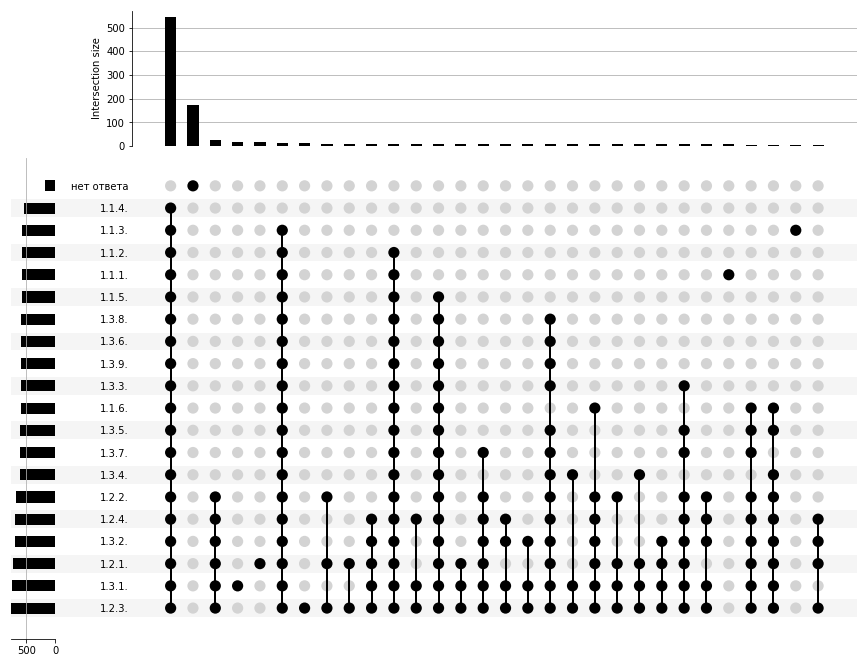

In [63]:
upsetplot.plot(example['c'][-30:], sort_by="cardinality")
plt.title('', loc='left')
plt.show()

In [64]:
# Build App
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
app.layout = html.Div(children=[
    html.Div([
        html.Div([
            html.H1("Порекомендуете ли Вы коллегам участие в курсе?"),
            dcc.Graph(
                id='graph1',
                figure=fig1
            ),
        ],className='six columns'),
        
        html.Div([
            html.H1("Планируете ли Вы принять участие в следующем курсе?"),
            dcc.Graph(
                id='graph2',
                figure=fig2
            ),
        ],className='six columns'),
    ], className='row'),
    
    html.Div([
        html.H1("Насколько курс был интересен для Вас?"),
        dcc.Graph(
            id='graph3',
            figure=fig3
        ),
    ],className='row'),
    html.Div([
        html.H1("Какие типы материалов были Вам наиболее удобны для работы?"),
        dcc.Graph(
            id='graph',
            figure=fig
        ),
    ],className='row'),
    
    html.Div([
        html.H1("Кто из спикеров Вам понравился?"),
        dcc.Graph(
            id='graph4',
            figure=fig4
        ),
    ],className='row'),
    html.Div([
        html.H1("Какие темы были для Вас наиболее полезны?"),
        dcc.Graph(
            id='graph5',
            figure=fig5
        ),
    ],className='row'),
    
    
   

])
# Run app and display result inline in the notebook
app.run_server()

Dash app running on http://127.0.0.1:8050/
